In [1]:
# https://towardsdatascience.com/generalized-linear-models-9cbf848bb8ab

import os
import sys
from collections import defaultdict
from functools import reduce, partial
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

from mutspec.utils.annot import translator

In [2]:
mut_raw = pd.read_csv("../data/processed/mutations.csv")
mut_raw

,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7606,Uterus,4.0,97.4400,2311,T,GTA,1,rRNA,RNR2,-1,-1,NaN,9749.0,NaN,0,G[T>C]A
7607,Uterus,4.0,20.5300,3417,C,CCA,1,CDS,ND1,111,3,CCC,11961.0,CCT,2,C[C>T]A
7608,Uterus,4.0,67.3200,5267,T,TTA,1,CDS,ND2,798,3,ATT,15661.0,ATC,1,T[T>C]A
7609,Uterus,4.0,4.7800,14775,T,CTA,1,CDS,CYTB,29,2,CTA,17954.0,CCA,0,C[T>C]A


In [3]:
mut_raw[mut_raw.TBSS.isna()]

,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
19,Bladder,200.0,1.14,152,T,CTA,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,C[T>C]A
20,Bone/SoftTissue,5373.0,57.94,152,T,CTA,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,C[T>C]A
21,Breast,84.5,1.01,152,T,CTA,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,C[T>C]A
22,Lymphoid,30.0,1.43,152,T,CTA,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,C[T>C]A
23,Prostate,120.0,12.28,152,T,CTA,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,C[T>C]A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7489,Skin,147.0,4.53,5773,G,GGT,-1,tRNA,TRNC,-1,-1,NaN,NaN,NaN,0,G[G>A]T
7519,Thyroid,4138.0,21.98,243,A,CAA,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,C[A>T]A
7533,Thyroid,4138.0,19.44,16250,C,TCC,-1,D-loop,NaN,-1,-1,NaN,NaN,NaN,0,T[C>T]C
7571,Uterus,4.0,7.08,5754,G,GGC,0,NaN,NaN,-1,-1,NaN,NaN,NaN,0,G[G>A]C


In [4]:
cols = "Mut TurnOverDays tumor_var_freq TBSS".split()
mut = mut_raw.dropna(subset="TBSS").loc[:, cols]
mut["Mut"] = mut["Mut"].str.slice(2, 5)
for sbs_l in mut.Mut.unique():
    sbs_h = sbs_l.translate(translator)
    sbs_h_styled = sbs_h[0] + "h>" + sbs_h[-1] + "h"
    mut[f"Dummy{sbs_h_styled}"] = (mut["Mut"] == sbs_l).astype(np.int8)
mut.head()

,Mut,TurnOverDays,tumor_var_freq,TBSS,DummyAh>Gh,DummyCh>Th,DummyTh>Ch,DummyTh>Gh,DummyCh>Gh,DummyGh>Ah,DummyAh>Th,DummyGh>Th,DummyAh>Ch,DummyCh>Ah,DummyTh>Ah,DummyGh>Ch
0,T>C,200.0,38.7900,10487.0,1,0,0,0,0,0,0,0,0,0,0,0
1,T>C,360.0,21.0500,10487.0,1,0,0,0,0,0,0,0,0,0,0,0
2,T>C,200.0,10.1400,426.0,1,0,0,0,0,0,0,0,0,0,0,0
3,G>A,200.0,37.3900,3816.0,0,1,0,0,0,0,0,0,0,0,0,0
4,G>A,11.0,0.7013,3816.0,0,1,0,0,0,0,0,0,0,0,0,0


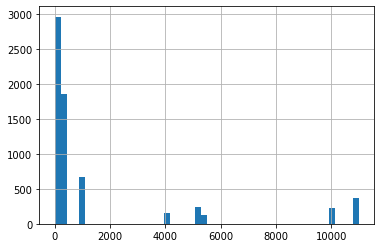

In [5]:
mut.TurnOverDays.hist(bins=50);

In [91]:
X = mut[cols[1:]]
X["DummyLowLongevity"] = (X.TurnOverDays < 2000).astype(int)
X["DummyMediumLongevity"] = ((X.TurnOverDays > 2000) & (X.TurnOverDays < 6000)).astype(int)
X["DummyHighLongevity"] = (X.TurnOverDays > 6000).astype(int)
X.drop("TurnOverDays", axis=1, inplace=True)
X.head()

,tumor_var_freq,TBSS,DummyLowLongevity,DummyMediumLongevity,DummyHighLongevity
0,38.7900,10487.0,1,0,0
1,21.0500,10487.0,1,0,0
2,10.1400,426.0,1,0,0
3,37.3900,3816.0,1,0,0
4,0.7013,3816.0,1,0,0


In [92]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6595 entries, 0 to 7610
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tumor_var_freq        6595 non-null   float64
 1   TBSS                  6595 non-null   float64
 2   DummyLowLongevity     6595 non-null   int64  
 3   DummyMediumLongevity  6595 non-null   int64  
 4   DummyHighLongevity    6595 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 309.1 KB


## prepare X and Y and scale features

In [93]:
# ????????
_cols = "tumor_var_freq	TBSS".split()
scaler = StandardScaler()
scaled_fea = scaler.fit_transform(X[_cols])
X_scaled = X.copy()
X_scaled.loc[:, _cols] = scaled_fea

scaler = StandardScaler()
scaled_fea_full = scaler.fit_transform(X)
X_scaled_full = X.copy()
X_scaled_full.loc[:, :] = scaled_fea_full

In [94]:
X.head()

,tumor_var_freq,TBSS,DummyLowLongevity,DummyMediumLongevity,DummyHighLongevity
0,38.7900,10487.0,1,0,0
1,21.0500,10487.0,1,0,0
2,10.1400,426.0,1,0,0
3,37.3900,3816.0,1,0,0
4,0.7013,3816.0,1,0,0


In [95]:
X_scaled.head()

,tumor_var_freq,TBSS,DummyLowLongevity,DummyMediumLongevity,DummyHighLongevity
0,0.725576,-0.094186,1,0,0
1,0.082337,-0.094186,1,0,0
2,-0.313252,-2.100632,1,0,0
3,0.674813,-1.424571,1,0,0
4,-0.655492,-1.424571,1,0,0


In [96]:
X_scaled_full.head()

,tumor_var_freq,TBSS,DummyLowLongevity,DummyMediumLongevity,DummyHighLongevity
0,0.725576,-0.094186,0.449612,-0.291346,-0.314325
1,0.082337,-0.094186,0.449612,-0.291346,-0.314325
2,-0.313252,-2.100632,0.449612,-0.291346,-0.314325
3,0.674813,-1.424571,0.449612,-0.291346,-0.314325
4,-0.655492,-1.424571,0.449612,-0.291346,-0.314325


### Check scaling

In [97]:
Y = mut[["DummyAh>Gh"]]
gamma_model = sm.GLM(Y, sm.add_constant(X), family=sm.families.Binomial())
gamma_results = gamma_model.fit(maxiter=1000)
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             DummyAh>Gh   No. Observations:                 6595
Model:                            GLM   Df Residuals:                     6590
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3931.3
Date:                Tue, 02 Aug 2022   Deviance:                       7862.6
Time:                        13:39:06   Pearson chi2:                 6.60e+03
No. Iterations:                     5   Pseudo R-squ. (CS):           0.003142
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.8131 

In [98]:
Y = mut[["DummyAh>Gh"]]
gamma_model = sm.GLM(Y, sm.add_constant(X_scaled_full), family=sm.families.Binomial())
gamma_results = gamma_model.fit(maxiter=1000)
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             DummyAh>Gh   No. Observations:                 6595
Model:                            GLM   Df Residuals:                     6590
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3931.3
Date:                Tue, 02 Aug 2022   Deviance:                       7862.6
Time:                        13:39:10   Pearson chi2:                 6.60e+03
No. Iterations:                   575   Pseudo R-squ. (CS):           0.003142
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.9227 

In [99]:
Y = mut[["DummyAh>Gh"]]
gamma_model = sm.GLM(Y, sm.add_constant(X_scaled), family=sm.families.Binomial())
gamma_results = gamma_model.fit(maxiter=1000)
print(gamma_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             DummyAh>Gh   No. Observations:                 6595
Model:                            GLM   Df Residuals:                     6590
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3931.3
Date:                Tue, 02 Aug 2022   Deviance:                       7862.6
Time:                        13:39:14   Pearson chi2:                 6.60e+03
No. Iterations:                   366   Pseudo R-squ. (CS):           0.003142
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.6700 

## GLM on all mutations

In [100]:
glm_data = []
for sbs in mut.columns[4:]:
    Y = mut[[sbs]]
    gamma_model = sm.GLM(Y, sm.add_constant(X_scaled), family=sm.families.Binomial())
    gamma_results = gamma_model.fit(maxiter=1000)
    one_data = {"mutation": sbs.replace("Dummy", "")}
    for fea in gamma_results.params.index:
        if gamma_results.pvalues[fea] < 0.05:
            one_data[fea] = gamma_results.params[fea]
        one_data[fea + "-pval"] = gamma_results.pvalues[fea]

    glm_data.append(one_data)

In [101]:
df = pd.DataFrame(glm_data)
df[["mutation"] + list(X.columns)].to_csv("../data/processed/glm_output_scaled_significant.ccsv", index=None)
df[["mutation"] + list(X.columns)].round(3)

,mutation,tumor_var_freq,TBSS,DummyLowLongevity,DummyMediumLongevity,DummyHighLongevity
0,Ah>Gh,0.073,0.065,-0.265,-0.363,NaN
1,Ch>Th,NaN,NaN,NaN,0.182,-0.129
2,Th>Ch,NaN,NaN,-0.746,-0.787,-0.622
3,Th>Gh,NaN,NaN,-1.372,-1.145,-0.637
4,Ch>Gh,NaN,NaN,-1.074,-1.118,-0.843
5,Gh>Ah,NaN,NaN,NaN,NaN,NaN
6,Ah>Th,NaN,NaN,NaN,NaN,NaN
7,Gh>Th,-0.422,NaN,-0.620,-1.380,-1.310
8,Ah>Ch,NaN,NaN,-1.834,-1.334,-1.052
9,Ch>Ah,NaN,NaN,-1.497,-1.197,-1.306


In [102]:
df

,mutation,const,const-pval,tumor_var_freq,tumor_var_freq-pval,TBSS,TBSS-pval,DummyLowLongevity,DummyLowLongevity-pval,DummyMediumLongevity,DummyMediumLongevity-pval,DummyHighLongevity-pval,DummyHighLongevity
0,Ah>Gh,-0.669997,4.635777e-86,0.072640,0.006485,0.064646,0.018420,-0.265056,3.992508e-11,-0.363206,3.702827e-06,0.554036,NaN
1,Ch>Th,0.068469,2.721712e-02,NaN,0.579585,NaN,0.062793,NaN,6.653678e-01,0.181977,9.324462e-03,0.049845,-0.129267
2,Th>Ch,-2.154749,1.339461e-217,NaN,0.434359,NaN,0.083822,-0.746430,2.249050e-20,-0.786511,6.292500e-07,0.000010,-0.621808
3,Th>Gh,-3.154200,1.962282e-144,NaN,0.161080,NaN,0.461108,-1.371937,4.105672e-19,-1.144855,1.088453e-04,0.006283,-0.637408
4,Ch>Gh,-3.034532,3.464473e-145,NaN,0.818742,NaN,0.445200,-1.074040,2.040947e-14,-1.117796,5.912588e-05,0.000396,-0.842696
5,Gh>Ah,NaN,7.914819e-01,NaN,0.973544,NaN,0.052045,NaN,7.914819e-01,NaN,7.914819e-01,0.791482,NaN
6,Ah>Th,NaN,9.999839e-01,NaN,0.349281,NaN,0.498600,NaN,9.999900e-01,NaN,9.999880e-01,0.999990,NaN
7,Gh>Th,-3.309885,2.768688e-99,-0.421765,0.001512,NaN,0.327028,-0.619538,2.355994e-04,-1.379849,9.458366e-05,0.000067,-1.310498
8,Ah>Ch,-4.220780,2.098459e-69,NaN,0.594888,NaN,0.843610,-1.834472,3.272994e-09,-1.333927,1.627579e-02,0.026457,-1.052381
9,Ch>Ah,-4.000181,1.313670e-76,NaN,0.255833,NaN,0.149067,-1.496945,5.822415e-09,-1.196790,9.448090e-03,0.004570,-1.306446
